## Pertubation of features-sampled domains

# Imports

In [1]:
from src.loader import load_graph
from classes import extract_all_features_single 
import sys
import os
from src import utils
import numpy as np
import pandas as pd
import torch
import torch_geometric.transforms as T
from src.utils import largest_indices
from src.utils import cal_n_add_facni 
from src.utils import extract_feat_adj2
from src.utils import calc_cad 
import networkx as nx
from scipy import spatial
import copy  
from matplotlib import pyplot as plt 
import random

# Routines

In [2]:
def confid_measures(arr_tri, Num):
    arr_tri_mean=np.mean(arr_tri,axis=0)
    std=np.std(arr_tri,axis=0)
    Z=1.960 # for 95 conf.
    upper=arr_tri_mean+Z*std/np.sqrt(Num)
    lower=arr_tri_mean-Z*std/np.sqrt(Num)
    return arr_tri_mean, lower, upper

def my_score(pred, labels):
    accuracy = (pred == labels).sum() / len(pred)
    return accuracy
def my_own_acc(a, b):
    acc = np.sum(np.equal(a, b)) / len(a)
    return acc

def do_perturb_feat(x,m):
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
#     x2=np.logical_or(x_bol,m_bol)
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def do_perturb_adj(a,m):
    a_bol=np.array(a, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    a2=np.logical_xor(a_bol,m_bol)
    a2=a2.astype(float)
    a2=torch.from_numpy(a2)
    return a2

def A_to_edge_index(A):
    G=nx.from_numpy_matrix(A)
    edge_index=list(G.edges)
    z=torch.tensor(np.transpose(edge_index))
    return z

def assign_Adversary_nas_mal(data, norm_zero_int):

    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()

    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal

    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)
    
    return adv_nodes_test

def get_As_new(adj_1, adj_2, adj_3, adj_4, adv_nodes):
    
    edge_list= np.concatenate(( adj_2.cpu(), adj_4.cpu()), axis=1)
   
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]
    A_adv=np.zeros( (len(adv_nodes),len(adv_nodes)), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv[lox_a,lox_b]=1 
    print("resssss", np.count_nonzero(A_adv))
   
    return A_adv

def extract_A(data, adv_nodes):
    edge_list_1=data.edge_index_dict['domain_node', 'apex', 'domain_node'][0,:]
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    common_node_lox=np.nonzero(np.in1d(edge_list_1.cpu(), adv_nodes))[0]
    adv_edge_list=edge_list[:,common_node_lox]
    A_adv=edge_list_to_adj(adv_edge_list.cpu())
    return A_adv

def edge_list_to_adj(adv_edge_lox1, adv_edge_lox2):
    elist=adv_edge_lox2
    print(elist)
    domain_node_list=np.unique(elist)
    domain_node_list=domain_node_list[0:4000]
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=adv_edge_lox1[k]
        b=adv_edge_lox2[k]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_As_jan(data, adv_nodes):
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:] 
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()
    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]
    L=len(adv_nodes)
    A_adv1=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv1[lox_a,lox_b]=1     
    print("sparsity", np.count_nonzero(A_adv1))    
    
    
    edge_list=data.edge_index_dict['domain_node', 'similar', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

    L=len(adv_nodes)
    A_adv2=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv2[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv2)) 
    
    
    A_adv=A_adv1+A_adv2
    
    return A_adv


def find_my_soln(WW):
    ATA=np.dot(WW,WW.T)
    w, v=np.linalg.eig(ATA)
    return v[:,0]

def calc_ASR(data, adv_nodes_test, model0):
    
    with torch.no_grad():
        model0.eval()
        pred_raw0 = model0(data.x_dict, data.edge_index_dict)
        pred_raw0 = F.softmax(pred_raw0, dim=1)
        y0_hat= pred_raw0.argmax(dim=-1)
        
    y0_hat=y0_hat[adv_nodes_test]    

    with torch.no_grad():
        model0.eval()
        pred_raw2 = model0(data.x_dict2, data.edge_index_dict)
        pred_raw2 = F.softmax(pred_raw2, dim=1)
        y2_hat= pred_raw2.argmax(dim=-1)
    y2_hat=y2_hat[adv_nodes_test]        

    num_of_1=0;
    num_of_1_forced_to_0=0;
    num_of_0=0;
    num_of_0_forced_to_1=0;
    
    for jj in range(len(y0_hat)):
        if y0_hat[jj]==1:
            num_of_1=num_of_1+1
        if y0_hat[jj]==1 and y2_hat[jj]==0:
            num_of_1_forced_to_0=num_of_1_forced_to_0+1;
            
        if y0_hat[jj]==0:
            num_of_0=num_of_0+1
        if y0_hat[jj]==0 and y2_hat[jj]==1:
            num_of_0_forced_to_1=num_of_0_forced_to_1+1;
            
    if num_of_1>0:
        ASRgood=num_of_1_forced_to_0/num_of_1
    else:
        ASRgood=num_of_1_forced_to_0

        
    if num_of_0>0:
        ASRbad=num_of_0_forced_to_1/num_of_0
    else:
        ASRbad=num_of_0_forced_to_1
        
    print("ASRgood", ASRgood, num_of_1_forced_to_0, num_of_1, "ASRbad", ASRbad, num_of_0_forced_to_1, num_of_0)
    return ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0
def flip_the_bins(x,lox):
    m=np.zeros_like(x)
    m[:,lox]=1
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def preds_of_adv(model0, data, adv_nodes_test):
    with torch.no_grad():
        model0.eval()
    pred_raw0 = model0(data.x_dict, data.edge_index_dict)
    y0_hat= pred_raw0.argmax(dim=-1)
    preds=y0_hat[adv_nodes_test]
    return preds
def model_qurey(model, data, idx_train):
    model.eval()
    pred_raw2 = model(data.x_dict2, data.edge_index_dict)
    pred_raw2 = F.softmax(pred_raw2, dim=1)
    y2_hat= pred_raw2.argmax(dim=-1)
    labels_sur=y2_hat[idx_train]
    
    return labels_sur

# Load DNS and mDNS datasets

In [3]:
import warnings
warnings.filterwarnings('ignore')
from src.loader2 import DNS2
kg_path = lambda graph_name: f'/home/sucharitha/MintA/myGraph_datasets/{graph_name}'
dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
data = dataset[0]
# dir(data)
# feats_2=cal_n_add_facni(kg_path('DNS_eid_adv'), data);
# torch.save(feats_2, 'feats_2.pt')
# This script is for eature extraction
# import warnings
# warnings.filterwarnings('ignore')
# dir(data)
# feats_new2=cal_n_add_facni(kg_path('DNS_eid_adv'), data);
# torch.save(feats_new2, 'feats_new2.pt')

# Feature assignment 
feats_new2=torch.load('feats_new2.pt')
data['domain_node'].x= feats_new2[0:data.x_dict['domain_node'].shape[0],:]
data['ip_node'].x=torch.zeros(data['ip_node'].x.shape[0],1)
data['host_node'].x=torch.zeros(data['host_node'].x.shape[0],1)
del feats_new2
# print(data.metadata)

# The MDD model 

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GATConv, HeteroConv, Linear

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers, add_self_loops=False):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: GATConv((-1,-1), hidden_channels, add_self_loops=add_self_loops)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)
        
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['domain_node'])
    
model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2,
                  num_layers=2)

In [5]:
torch.cuda.set_device(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data=data.to(device)
model=model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
           
def train(model,data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['domain_node'].train_mask
    loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model,data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data[split]
        acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

In [6]:
from deeprobust.graph.defense import GCN

# datya to train the surrog
train_mask = data['domain_node'].train_mask
labels_train=data['domain_node'].y.cpu()
labelled_labels_train_lox=np.where(labels_train<2)
lox_train=np.where(train_mask.cpu()>0)
lox_train=lox_train[0]
labels=data['domain_node'].y.cpu()
lox_train_space=labelled_labels_train_lox
adv_nodes_train=lox_train_space[0][0:4000]
Adj_sur=extract_As_jan(data, adv_nodes_train)
features_sur=data['domain_node'].x[adv_nodes_train]
features_sur=np.array(features_sur.cpu())
data.x_sur=features_sur
idx_train=np.arange(4000)

sparsity 3802
sparsity 2322


# The proposed MinstA

In [7]:
def one_trial():   
    # init and a train a new model instance
    dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
    data = dataset[0]
    feats_new=torch.load('feats_new2.pt')
    data['domain_node'].x= feats_new[0:data.x_dict['domain_node'].shape[0],:]
    data['ip_node'].x=torch.zeros(data['ip_node'].x.shape[0],1)
    data['host_node'].x=torch.zeros(data['host_node'].x.shape[0],1)
    del feats_new
    
    adv_nodes_test=assign_Adversary_nas_mal(data,100)
    A_adv=extract_As_jan(data, adv_nodes_test)
    
    perf_arr=np.empty((6,0))
    val_nodes=np.array([1,5,20,40,60,80,100])
    
    # init and train a new clean model:
    model0= HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2, num_layers=2)
    data, model0 = data.to(device), model0.to(device)
    data.x_dict2=copy.deepcopy(data.x_dict)
    
    for epoch in range(201):
        loss=train(model0,data)
        
    labels_sur=model_qurey(model0, data, idx_train)
    labels_sur=np.array(labels_sur.cpu())
    
    preds=preds_of_adv(model0, data, adv_nodes_test)

    # init and train a new surrogate
    surrogate = GCN(nfeat=features_sur.shape[1], nclass=2,
                nhid=64, dropout=0, with_relu=False, with_bias=False, device='cpu')
    surrogate.fit(features_sur, Adj_sur, labels_sur, idx_train)
  
    for val in val_nodes: 
        print(val)
        x=data['domain_node'].x.cpu()
        x2=copy.deepcopy(x)
        X=x[adv_nodes_test,:].cpu()
        X=np.array(X)
        A=A_adv
        X2=copy.deepcopy(X)
        all_lox=np.arange(45)
        w1=surrogate.gc1
        W=w1.weight.data
        W1=np.array(W.cpu())
        F1=find_my_soln(W1)

        for zzz in range(8):
            for i in np.arange(val):
                if preds[i]>0:
                    temp=A[i,:];
                    js=np.flatnonzero(temp) 
                    messages=np.dot(A, X2)
                    F2=0*F1
                    for kk in np.arange(len(js)):
                        message_j=messages[js[kk],:]

                        W2=copy.deepcopy(W1)
                        d_j=len(js)
                        for kkk in np.arange(64):
                            if d_j>0:
                                W2[:,kkk]=W1[:,kkk]-1/d_j*message_j
                            F2=F2+find_my_soln(W2)    
                    feat_up=(1*F1+1*F2)/2
                    X2[i,6:]=X2[i,6:]+feat_up[6:]   

        x2[adv_nodes_test,:]=torch.from_numpy(X2)  
        x2=x2.to(device)
        data.x_dict2['domain_node']=x2
        ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0=calc_ASR(data, adv_nodes_test, model0) 

        temp=np.array([ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0]).reshape(-1,1)
        perf_arr = np.hstack((perf_arr, temp))
        
    return perf_arr    

In [8]:
Num=30
res_arr=np.zeros((Num, 6,7))
for tri in range(Num):       
    g1=one_trial()
    res_arr[tri,:,:]=g1

sparsity 82
sparsity 52
1
ASRgood 0.0 0 10 ASRbad 0.0 0 90
5
ASRgood 0.1 1 10 ASRbad 0.0 0 90
20
ASRgood 0.1 1 10 ASRbad 0.0 0 90
40
ASRgood 0.2 2 10 ASRbad 0.011111111111111112 1 90
60
ASRgood 0.2 2 10 ASRbad 0.011111111111111112 1 90
80
ASRgood 0.3 3 10 ASRbad 0.011111111111111112 1 90
100
ASRgood 0.5 5 10 ASRbad 0.011111111111111112 1 90
sparsity 100
sparsity 31
1
ASRgood 0.046875 3 64 ASRbad 0.0 0 36
5
ASRgood 0.046875 3 64 ASRbad 0.0 0 36
20
ASRgood 0.328125 21 64 ASRbad 0.0 0 36
40
ASRgood 0.453125 29 64 ASRbad 0.0 0 36
60
ASRgood 0.515625 33 64 ASRbad 0.0 0 36
80
ASRgood 0.5625 36 64 ASRbad 0.0 0 36
100
ASRgood 0.609375 39 64 ASRbad 0.0 0 36
sparsity 65
sparsity 48
1
ASRgood 0.0 0 50 ASRbad 0.0 0 50
5
ASRgood 0.0 0 50 ASRbad 0.0 0 50
20
ASRgood 0.0 0 50 ASRbad 0.0 0 50
40
ASRgood 0.0 0 50 ASRbad 0.0 0 50
60
ASRgood 0.0 0 50 ASRbad 0.0 0 50
80
ASRgood 0.0 0 50 ASRbad 0.0 0 50
100
ASRgood 0.0 0 50 ASRbad 0.0 0 50
sparsity 67
sparsity 37
1
ASRgood 0.0 0 67 ASRbad 0.0 0 33
5
ASRgood

In [9]:
arr1 = np.mean(res_arr, axis = 0)
avg_mal_num=res_arr[:,2,:].mean()
avg_ben_num=res_arr[:,5,:].mean()

# Plot results

In [10]:
val_nodes=np.array([1,5,20,40,60,80,100])

In [11]:
plt.rcParams['font.size'] = 17
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Plot ASR

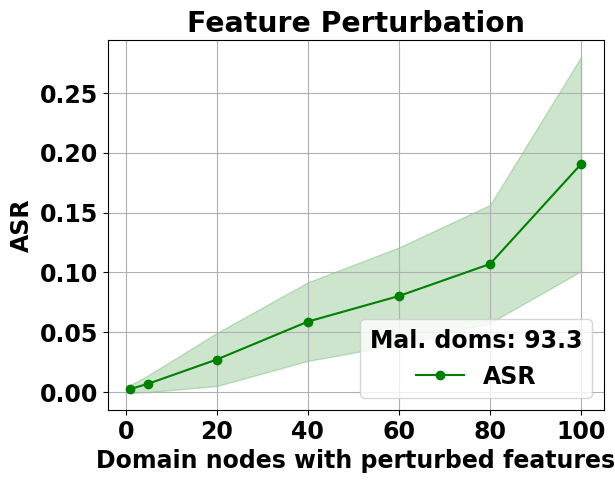

In [15]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_feat_Sampled_doms'):
    os.makedirs('RESULTS_feat_Sampled_doms')
plt.figure(facecolor='white')
plt.title("Feature Perturbation")
plt.xlabel("Domain nodes with perturbed features", weight='bold') 
plt.ylabel("ASR", weight='bold') 
# plot the ASR:
m0, l0, u0=confid_measures(res_arr[:,0,:], Num)
plt.plot(val_nodes, m0,'-og', label=('ASR'))
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
legend_text = 'Mal. doms: %.1f' % (93.29)
plt.legend(loc='lower right', fontsize="11",prop=dict(weight='bold'),title=legend_text)
plt.grid()
name='RESULTS_feat_Sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_feat_Sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()

## Plot NFR

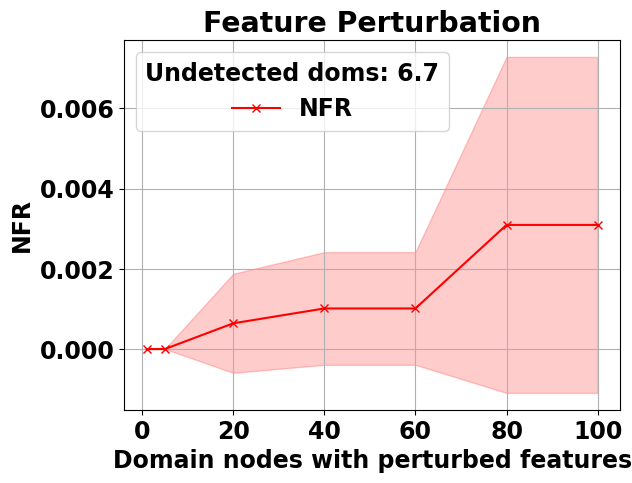

In [16]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_feat_Sampled_doms'):
    os.makedirs('RESULTS_feat_Sampled_doms')
plt.figure(facecolor='white')
plt.title("Feature Perturbation")
plt.xlabel("Domain nodes with perturbed features", weight='bold') 
plt.ylabel("NFR", weight='bold') 
m3, l3, u3=confid_measures(res_arr[:,3,:], Num)
plt.plot(val_nodes, m3,'-xr', label=("NFR"))
plt.fill_between(num_change_arr, l3, u3, color='red', alpha=0.2)
plt.grid()
legend_text = 'Undetected doms: %.1f' % (6.71)
plt.legend(loc='upper left', fontsize="11",prop=dict(weight='bold'),title=legend_text)
name='RESULTS_feat_Sampled_doms/asr_plot3_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_feat_Sampled_doms/asr_plot3_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()

## Plot ROC

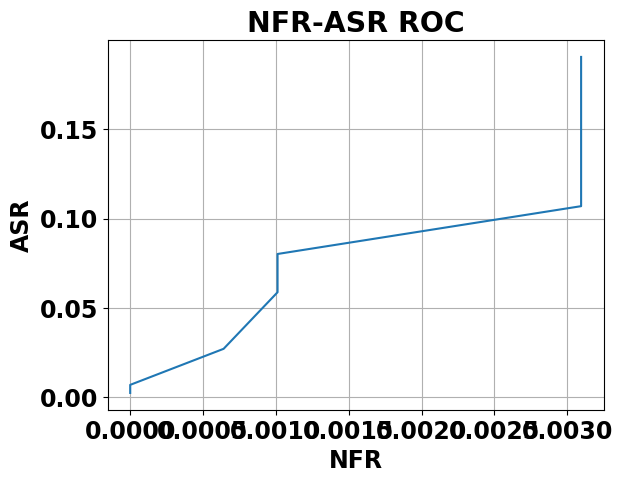

In [17]:
tpr=m0
fpr=m3
plt.figure(facecolor='white')
plt.title("NFR-ASR ROC")
plt.xlabel("NFR", weight='bold') 
plt.ylabel("ASR", weight='bold') 
plt.plot(fpr, tpr) 
plt.grid()
name='RESULTS_feat_Sampled_doms/ROC_'+ str(Num)+'.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_feat_Sampled_doms/ROC_'+ str(Num)+'.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()